# LSTM


## Mount Google Drive

In [8]:
# Colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

## Install

In [9]:
# !java -version
# %pip install konlpy

## Import Library

In [10]:
# data
import pandas as pd
import pickle

# preprocessing
from konlpy.tag import Komoran
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# env
import os
from tqdm import tqdm
import hangul_font

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

## GPU Check

In [ ]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')

## Hyper parameters

In [10]:
# Path
# Colab
# DATA_DIR = '/content/drive/MyDrive/miso/intelli/data/'
# SAVE_DIR = '/content/drive/MyDrive/miso/intelli/model/LSTM/'
# LOAD_DIR = '/content/drive/MyDrive/miso/intelli/model/LSTM/'

# Local
DATA_DIR = '/Users/inseoklee/Desktop/miso/intelli/data/'
SAVE_DIR = '/Users/inseoklee/Desktop/miso/intelli/model/LSTM/'
LOAD_DIR = '/Users/inseoklee/Desktop/miso/intelli/model/LSTM/'

# Model
# MAX_LEN -> 패딩 단계에서 설정
OUTPUT_DIM = 128 # Embedding layer
UNITS = 64 # LSTM layer
DROPOUT = 0.2 # LSTM layer
OUTPUT = 7 # Dense layer

# Evaluation
EPOCHS = 10
VERBOSE = 1
BATCH_SIZE = 128
PATIENCE = 3
VALIDATION_SPLIT = 0.2

## Load Data

In [11]:
df = pd.read_csv(DATA_DIR + 'intelli.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15051 entries, 0 to 15050
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   답변      15051 non-null  object
 1   지능      15051 non-null  object
dtypes: object(2)
memory usage: 235.3+ KB


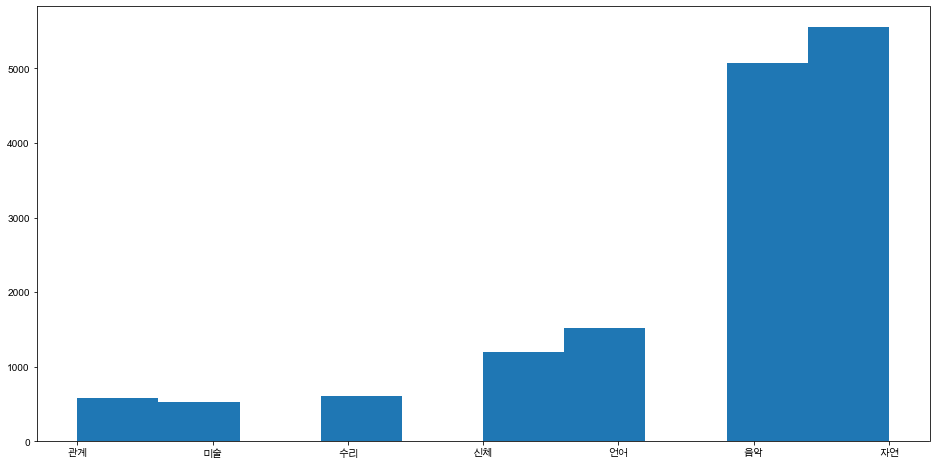

In [12]:
label = df['지능']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

## Train Test Split

In [13]:
X = df.답변
y = df.지능

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [14]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (12040,)
y_train shape:  (12040,)

X_test shape:  (3011,)
y_test shape:  (3011,)


## Preprocessing

### Train Tokenization

In [15]:
komoran = Komoran()

# 불용어(Stop Words) 제거
stop_pos_tags = ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX',
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH',
                   'SW', 'NF', 'NV', 'SN', 'NA']

# 어간 원형 복원(Lemmatization)
# 동사와 형용사의 경우에는 어간(Stem)에 '다'를 붙여서 기본형으로 복원
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.pos(corpus)
    for pair in pairs:
        morph, pos = pair
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    return result

JVMNotFoundException: No JVM shared library file (libjli.dylib) found. Try setting up the JAVA_HOME environment variable properly.

In [11]:
# 토큰을 만들고 리스트에 저장
clean_train_text = []
for sample in tqdm(X_train):
    clean_train_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 12040/12040 [00:03<00:00, 3718.61it/s]


In [12]:
clean_train_text[:3]

[['삽화', '을', '읽다', '것', '좋다', '고', '듣다', '게', '좋다', '아'],
 ['나', '도사', '푸란', '구경', '하', '게', '좋다', '아'],
 ['백파이프', '배우다', '게', '즐겁다', '어']]

### Test Tokenization

In [13]:
# 토큰을 만들고 리스트에 저장
clean_test_text = []
for sample in tqdm(X_test):
    clean_test_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 3011/3011 [00:00<00:00, 4972.41it/s]


### Vectorization

In [14]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token=True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)

except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

print(train_sequences[:3])

[[216, 13, 25, 72, 9, 18, 21, 3, 9, 4], [5, 873, 874, 15, 2, 3, 9, 4], [143, 23, 3, 11, 7]]


### Set vocab_size

In [15]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

1913


### Get vocab items

In [16]:
token_dic = tokenizer.word_counts
d2 = sorted(token_dic.items(), key=lambda x: x[1], reverse=True)
print(d2)

[('하', 9230), ('게', 8788), ('아', 5912), ('나', 4001), ('잘', 3611), ('어', 3274), ('거', 3163), ('좋다', 2951), ('신', 2856), ('즐겁다', 2848), ('연주', 2036), ('을', 2034), ('면서', 2013), ('구경', 1766), ('관찰', 1724), ('소리', 1496), ('고', 1335), ('하다', 1241), ('있다', 825), ('듣다', 722), ('는지', 714), ('배우다', 690), ('되다', 659), ('읽다', 644), ('내다', 599), ('나다', 589), ('주다', 510), ('노래', 433), ('르', 415), ('보다', 412), ('부르다', 406), ('이다', 388), ('지', 384), ('뭔', 367), ('싶다', 367), ('치다', 355), ('놀다', 355), ('어떤', 339), ('음악', 331), ('여러', 327), ('먹이', 326), ('무슨', 323), ('기르다', 322), ('악기', 320), ('가지다', 320), ('예', 319), ('어요', 313), ('맞히다', 304), ('흉내', 301), ('입', 284), ('이야기', 259), ('친구', 249), ('이', 235), ('뛰다', 229), ('그림', 203), ('치', 197), ('속', 189), ('놓다', 181), ('꿈', 172), ('식물', 150), ('수', 138), ('만들다', 124), ('시간', 124), ('어서', 123), ('엄마', 123), ('들', 120), ('가', 114), ('아빠', 113), ('그리다', 111), ('지다', 108), ('것', 106), ('과', 103), ('어떻다', 99), ('많이', 99), ('나오다', 97), ('으면', 96), ('맞추다', 96

### Padding

텍스트의 최대 길이 : 46
텍스트의 평균 길이 : 7.997009966777409


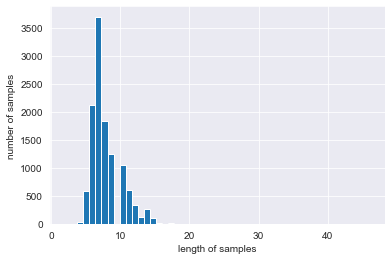

In [17]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = int(max(len(text) for text in train_sequences) * 95 / 100)

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

## Labeling

In [19]:
y_train.unique()

array(['언어', '자연', '음악', '수리', '미술', '신체', '관계'], dtype=object)

In [20]:
intelli_dic = {
    '관계': 0, '미술': 1, '수리': 2, '신체': 3, '언어': 4, '음악': 5, '자연': 6
}

In [21]:
y_train = y_train.replace(intelli_dic)
y_test = y_test.replace(intelli_dic)
y_train.unique()

array([4, 6, 5, 2, 1, 3, 0])

## Model definition

In [22]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(LSTM(units=UNITS, dropout=DROPOUT))#, recurrent_dropout=RECURRENT_DROPOUT))
model.add(Dense(units=OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR + 'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-08-03 13:30:12.421809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 13:30:12.421834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train

In [23]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es, mcp], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/10


2022-08-03 13:30:13.183769: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-03 13:30:14.708216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 13:30:14.960535: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_19'
2022-08-03 13:30:14.963983: I tensorflow/core/grappler/optimizers/cu

76/76 [==============================] - ETA: 0s - loss: 1.5863 - accuracy: 0.3583

2022-08-03 13:30:19.848173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 13:30:19.998969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.36213, saving model to /Users/inseoklee/Desktop/miso/intelli/model/LSTM/best-model.h5
76/76 [==============================] - 7s 67ms/step - loss: 1.5863 - accuracy: 0.3583 - val_loss: 1.5725 - val_accuracy: 0.3621
Epoch 2/10
75/76 [============================>.] - ETA: 0s - loss: 1.3990 - accuracy: 0.3997
Epoch 2: val_accuracy improved from 0.36213 to 0.45681, saving model to /Users/inseoklee/Desktop/miso/intelli/model/LSTM/best-model.h5
76/76 [==============================] - 3s 44ms/step - loss: 1.3980 - accuracy: 0.4001 - val_loss: 1.0845 - val_accuracy: 0.4568
Epoch 3/10
75/76 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.4556
Epoch 3: val_accuracy did not improve from 0.45681
76/76 [==============================] - 3s 44ms/step - loss: 1.0369 - accuracy: 0.4564 - val_loss: 1.0449 - val_accuracy: 0.4547
Epoch 4/10
75/76 [============================>.] - ETA: 0s - loss: 1.0161 - accuracy: 0.4557
Epoch 4: 

## Test

In [24]:
loaded_model = load_model(LOAD_DIR + 'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)
print('Test loss: ', loss)
print('Test accuracy: ', acc)

2022-08-03 13:30:41.525151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 13:30:41.653088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 2s 15ms/step - loss: 1.0009 - accuracy: 0.4616
Test loss:  1.0009101629257202
Test accuracy:  0.4616406261920929


## Visualization

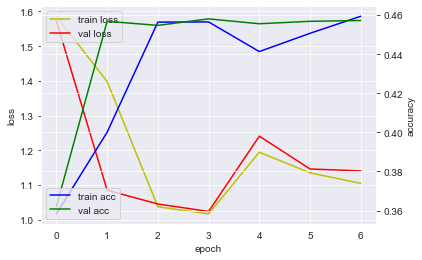

In [25]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save model

In [26]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/inseoklee/Desktop/miso/intelli/model/LSTM/trained-model.h5 


## Evaluation

In [27]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

2022-08-03 13:30:43.795552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 13:30:43.921540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 2s 13ms/step
[6 4 6 ... 6 6 6]


### Confusion matrix

[[   0    0    0    0  116    0    0]
 [   0    0    0    0  105    0    1]
 [   0    0    0    0  120    0    1]
 [   0    0    0    0  239    0    0]
 [   0    0    0    0  303    0    0]
 [   0    0    0    0   20    0  995]
 [   0    0    0    0   24    0 1087]]


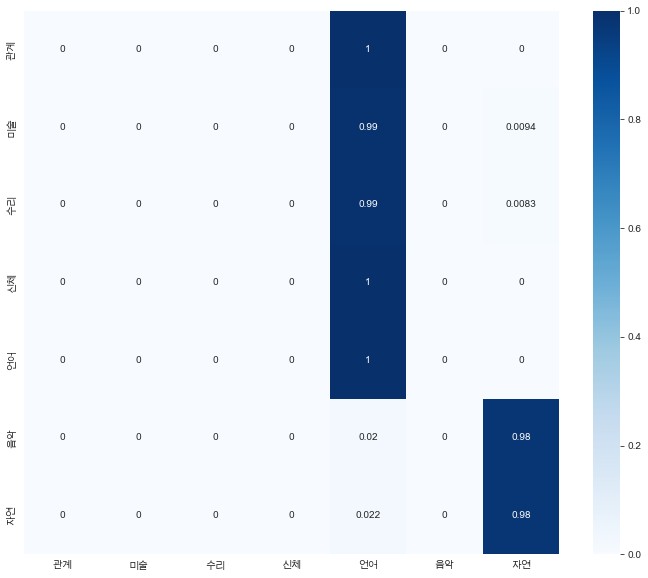

In [28]:
# constant for classes
classes = ('관계', '미술', '수리', '신체', '언어', '음악', '자연')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(7, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

### precision, recall, f1 score

In [29]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.4616406509465294
precision_score:  0.12120770451929723
recall_score:  0.2826282628262827
f1_score:  0.16758873021325787


/Users/inseoklee/miniforge3/envs/intelli/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Load Model

In [30]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained-model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [31]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_label(text, model):
    tokens = []
    tokenized = tokenize(text, stop_pos_tags)
    if(len(tokenized) == 0) :
        return "너무 짧아"
    tokens.append(tokenized)
    tokens = tokenizer.texts_to_sequences(tokens)
    x_test = pad_sequences(tokens, maxlen=MAX_LEN)
    predict = model.predict(x_test)
    # print(predict)
    result = getResult(predict[0])
    # '관계', '미술', '수리', '신체', '언어', '음악', '자연'
    if result == 0 :
        return '관계'
    elif result == 1 :
        return '미술'
    elif result == 2 :
        return '수리'
    elif result == 3 :
        return '신체'
    elif result == 4 :
        return '언어'
    elif result == 5 :
        return '음악'
    elif result == 6 :
        return '자연'

## 3가지 레이블에 대한 예측

'미술' 라벨에 대한 예측

In [32]:
predict_label("나는 동물을 크레파스로 그리는게 신나", model)

2022-08-03 13:30:47.302695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 13:30:47.428273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


'언어'

'관계' 라벨에 대한 예측

In [33]:
predict_label("나는 친구를 도와줘서 칭찬을 받는게 좋아", model)

1/1 [==============================] - 0s 179ms/step


'신체'

'수리'라벨에 대한 예측

In [34]:
predict_label("나는 숫자를 공부해서 나중에 프로그래머가 되고 싶어요", model)

1/1 [==============================] - 0s 184ms/step


'신체'